# GOJARAWALU DETECTION

Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE_X = 256
IMAGE_SIZE_Y = 512
CHANNELS=3
EPOCHS=100

Import data into tensorflow dataset objec

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE_Y,IMAGE_SIZE_X),
    batch_size=BATCH_SIZE
)

Found 803 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['gojarawalu-dataset-1', 'gojarawalu-dataset-2', 'healty-paddy-leaves']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 512, 256, 3)
[2 2 2 1 2 1 1 1 2 1 2 1 1 1 0 2 2 2 1 1 2 1 1 2 2 2 1 2 1 0 2 1]


Visualize some of the images from our dataset

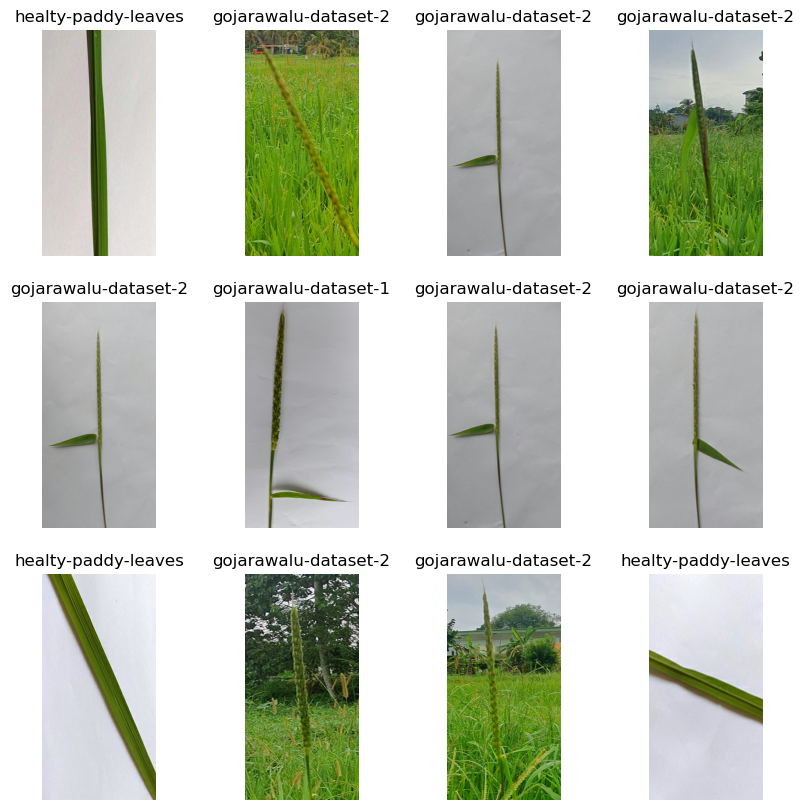

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset

In [7]:
len(dataset)

26

In [8]:
train_size = 0.8
len(dataset)*train_size

20.8

In [9]:
train_ds = dataset.take(54)
len(train_ds)

26

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

0

In [11]:
val_size=0.1
len(dataset)*val_size

2.6

In [12]:
val_ds = test_ds.take(6)
len(val_ds)


0

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

0

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

20

In [17]:
len(val_ds)

2

In [18]:
len(test_ds)

4

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE_Y, IMAGE_SIZE_X),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE_X, IMAGE_SIZE_Y, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 512, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 510, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 255, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 253, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 126, 62, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 124, 60, 64)        

Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
20/20 [==============================] - 59s 3s/step - loss: 0.8776 - accuracy: 0.5609 - val_loss: 0.5577 - val_accuracy: 0.7656
Epoch 2/100
20/20 [==============================] - 57s 3s/step - loss: 0.5312 - accuracy: 0.7766 - val_loss: 0.3501 - val_accuracy: 0.7969
Epoch 3/100
20/20 [==============================] - 62s 3s/step - loss: 0.4145 - accuracy: 0.8484 - val_loss: 0.2470 - val_accuracy: 0.8594
Epoch 4/100
20/20 [==============================] - 57s 3s/step - loss: 0.3506 - accuracy: 0.8594 - val_loss: 0.1734 - val_accuracy: 0.9375
Epoch 5/100
20/20 [==============================] - 54s 3s/step - loss: 0.3106 - accuracy: 0.8766 - val_loss: 0.1558 - val_accuracy: 0.9375
Epoch 6/100
20/20 [==============================] - 52s 3s/step - loss: 0.2918 - accuracy: 0.8813 - val_loss: 0.1323 - val_accuracy: 0.9375
Epoch 7/100
20/20 [==============================] - 53s 3s/step - loss: 0.2774 - accuracy: 0.8844 - val_loss: 0.1408 - val_accuracy: 0.9219
Epoch 8/100
2

Epoch 59/100
20/20 [==============================] - 50s 2s/step - loss: 0.0833 - accuracy: 0.9688 - val_loss: 0.0272 - val_accuracy: 0.9844
Epoch 60/100
20/20 [==============================] - 49s 2s/step - loss: 0.0948 - accuracy: 0.9703 - val_loss: 0.0388 - val_accuracy: 0.9844
Epoch 61/100
20/20 [==============================] - 51s 3s/step - loss: 0.0662 - accuracy: 0.9766 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 62/100
20/20 [==============================] - 50s 2s/step - loss: 0.0472 - accuracy: 0.9812 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 63/100
20/20 [==============================] - 50s 2s/step - loss: 0.0749 - accuracy: 0.9734 - val_loss: 0.0170 - val_accuracy: 1.0000
Epoch 64/100
20/20 [==============================] - 47s 2s/step - loss: 0.0647 - accuracy: 0.9812 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 65/100
20/20 [==============================] - 53s 3s/step - loss: 0.0610 - accuracy: 0.9797 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 

In [27]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 3s 512ms/step - loss: 0.0215 - accuracy: 0.9922


In [28]:
scores

[0.02152959443628788, 0.9921875]

Plotting the Accuracy and Loss Curves

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 20}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

100

In [34]:
history.history['loss'][:10] # show loss for first 10 epochs

[0.8775993585586548,
 0.5311700105667114,
 0.4144528806209564,
 0.35060355067253113,
 0.3106458783149719,
 0.2917892038822174,
 0.27739810943603516,
 0.2553386390209198,
 0.30761051177978516,
 0.23980262875556946]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

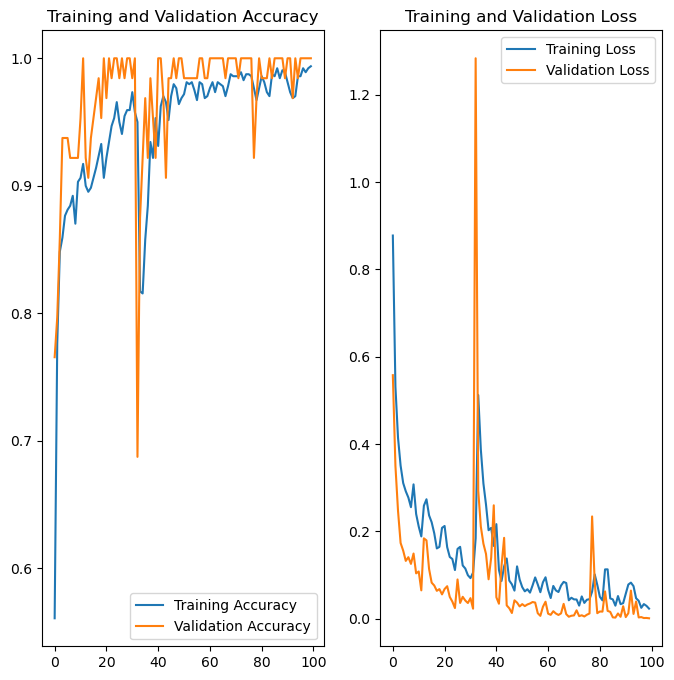

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: healty-paddy-leaves
predicted label: healty-paddy-leaves


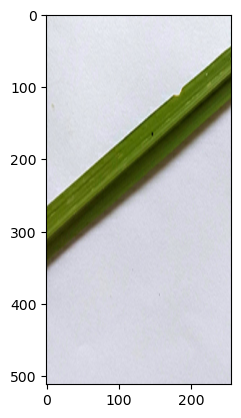

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

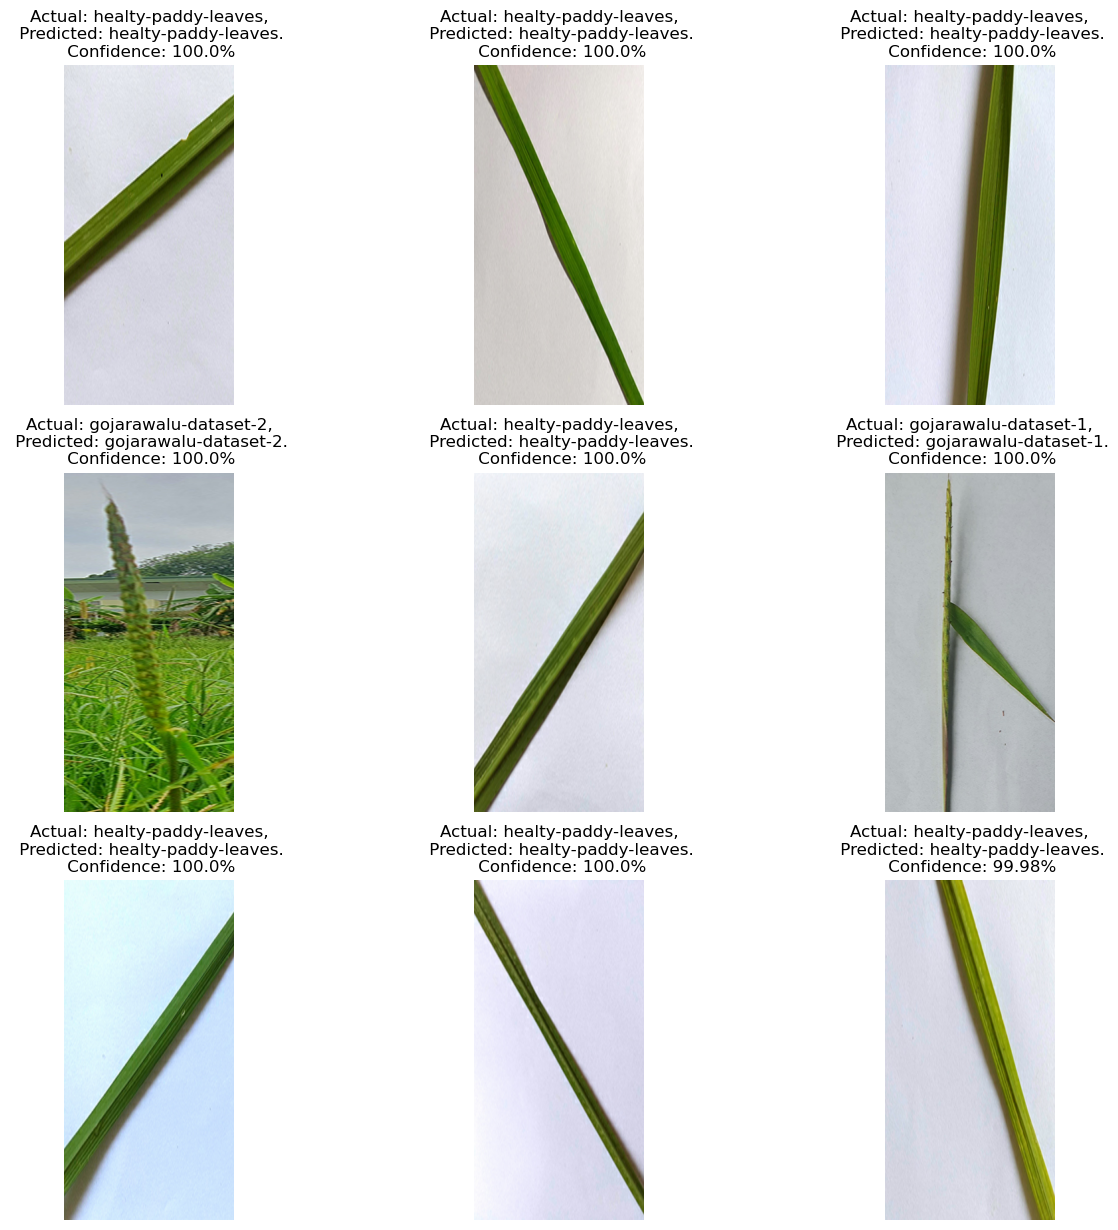

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

In [40]:
#import os
#model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
#model.save(f"../models/{model_version}")

In [41]:
#model.save("../gojarawalu.h5")

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the test dataset
y_pred = np.argmax(model.predict(test_ds), axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a histogram
plt.figure(figsize=(8, 8))
plt.hist2d(y_true, y_pred, bins=(len(class_names), len(class_names)), cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted label')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylabel('True label')
plt.yticks(range(len(class_names)), class_names)
plt.title('Confusion matrix')
plt.show()


4/4 [==============================] - 2s 526ms/step - loss: 0.0215 - accuracy: 0.9922
Test loss: 0.02152959257364273
Test accuracy: 0.9921875
Confusion matrix:
[[15  3  7]
 [ 3 15  6]
 [ 8  5 66]]


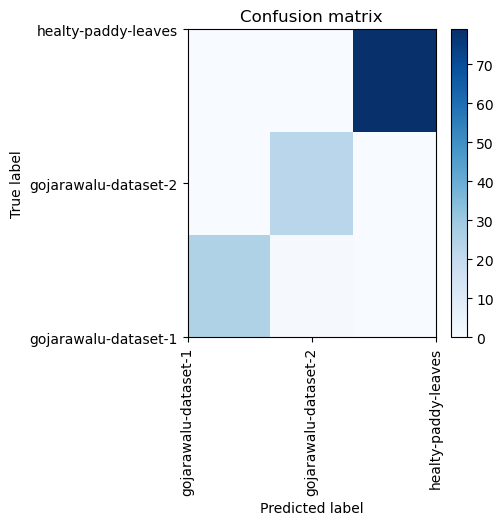

In [50]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the test dataset
y_pred = np.argmax(model.predict(test_ds), axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a histogram
plt.figure(figsize=(4, 4))
plt.hist2d(y_true, y_pred, bins=(len(class_names), len(class_names)), cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel('Predicted label')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.ylabel('True label')
plt.yticks(range(len(class_names)), class_names)
plt.title('Confusion matrix')
plt.show()


In [52]:
from sklearn.metrics import classification_report

# predict class probabilities for test set
y_pred_proba = model.predict(test_ds)

# get class predictions from probabilities
y_pred = tf.argmax(y_pred_proba, axis=1)

# get true labels for test set
y_true = []
for x, y in test_ds:
    y_true.extend(y.numpy())

# generate classification report
target_names = ['gojarawalu', 'gojarawalu', 'Healthy']
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

  gojarawalu       0.35      0.36      0.35        25
  gojarawalu       0.26      0.25      0.26        24
     Healthy       0.71      0.71      0.71        79

    accuracy                           0.55       128
   macro avg       0.44      0.44      0.44       128
weighted avg       0.55      0.55      0.55       128

